In [1]:
import fitz  # PyMuPDF
import re
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.enums import TA_LEFT
from reportlab.platypus import Image

d:\Downloads\data_for_MlAssist\jupyter_files\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
pdf_path = '../question papers/paper2.pdf' # Path to the PDF file (question paper)
df=pd.read_csv("../question papers/paper1_results.csv") # Path to the CSV file (results)
model_path = "../saved models/bert-chapter-classification-model" # Path to the trained model
question_bank=pd.read_csv("../Screenshots/questions.csv") # Path to the CSV file (question bank)
question_bank['Chapter'] = question_bank['Chapter'].str.strip()

# Load the trained FastText model

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

# Function to remove known redundant sections
def remove_redundant_sections(text):
    # Add patterns for known redundant sections
    patterns = [
        '\n•\nThis question paper contains two sections, section A & B.\n•\nSection A contains 20 multiple choice questions (SCQs) with four options (A),(B),(C),(D) out\nof which only one option is correct.\n•\nSection B contains 10 Integer Type questions, out of which candidate have to attempt only 5\nquestions.\nSection-I\n•\nThis Section contain 20 questions (Q.No. 1 to Q.No. 20)\n•\nAnswer to each question in Section A will be evaluated according to the following marking\nscheme:\nFull Marks \n:    +𝟒   for correct answer\nZero Marks \n:       0   If the question is unanswered;\nNegative Marks :    −𝟏  for incorrect answer\nCLASS 12th','This question paper contains two sections','\n•\nThis question paper contains two sections','\nJEE MAIN PAPER\nVIJETA BATCH \nCLASS 12th','\nJEE MAIN PAPER\nVIJETA BATCH \nCLASS 12th\n3','CLASS 12th.*?\n','question paper contains two sections''\nSection-II','\n•\nThis Section contain 10 questions (Q.No. 21 to Q.No. 30) whose answer to be filled as\nnumerical value (Attempt any five)\n•\nAnswer to each question in Section B will be evaluated according to the following marking\nscheme:\nFull Marks \n:    +𝟒   for correct answer \nZero Marks \n:       0   If the question is unanswered;\nZero Marks \n:       𝟎  for incorrect answer \n4','5\nPART – 2 : PHYSICS','\n•\n, section A & B.\n•\nSection A contains 20 multiple choice questions (SCQs) with four options (A),(B),(C),(D) out\nof which only one option is correct.\n•\nSection B contains 10 Integer Type questions, out of which candidate have to attempt only 5\nquestions.\nSection-I\n•\nThis Section contain 20 questions (Q.No. 1 to Q.No. 20)\n•\nAnswer to each question in Section A will be evaluated according to the following marking\nscheme:\nFull Marks \n:    +𝟒   for correct answer\nZero Marks \n:       0   If the question is unanswered;\nNegative Marks :    −𝟏  for incorrect answer\n6','\n•\nThis Section contain 10 questions (Q.No. 21 to Q.No. 30) whose answer to be filled as\nnumerical value (Attempt any five)\n•\nAnswer to each question in Section B will be evaluated according to the following marking\nscheme:\nFull Marks \n:    +𝟒   for correct answer \nZero Marks \n:       0   If the question is unanswered;\nZero Marks \n:       𝟎  for incorrect answer \n11','\nPART – 3 : CHEMISTRY','\n•\n, section A & B.\n•\nSection A contains 20 multiple choice questions (SCQs) with four options (A),(B),(C),(D) out\nof which only one option is correct.\n•\nSection B contains 10 Integer Type questions, out of which candidate have to attempt only 5\nquestions.\nSection-I\n•\nThis Section contain 20 questions (Q.No. 1 to Q.No. 20)\n•\nAnswer to each question in Section A will be evaluated according to the following marking\nscheme:\nFull Marks \n:   +𝟒   for correct answer\nZero Marks \n:       0   If the question is unanswered;\nNegative Marks :    −𝟏  for incorrect answer\n13','\n•\nThis Section contain 10 questions (Q.No. 21 to Q.No. 30) whose answer to be filled as\nnumerical value (Attempt any five)\n•\nAnswer to each question in Section B will be evaluated according to the following marking\nscheme:\nFull Marks \n:    +𝟒   for correct answer \nZero Marks \n:       0   If the question is unanswered;\nZero Marks \n:       𝟎  for incorrect answer \n17','\nJEE MAIN PAPER\nVIJETA BATCH \n',
    ]
    for pattern in patterns:
        text = text.replace(pattern,'')
    return text

# Function to split the text into individual questions
def split_questions(text):
    # Assuming questions are numbered and each starts with a new line and a number (e.g., 1., 2., ...)
    questions = re.split(r'\n\d+\.\s+', text)
    # Remove the first element if it's empty (because of the split)
    if questions[0].strip() == "":
        questions.pop(0)
    return questions

topics=[]
# Function to process the PDF and categorize each question
def pdf_to_csv(pdf_path):
    global topics 
    global questions
    text = extract_text_from_pdf(pdf_path)
    text = remove_redundant_sections(text)
    questions = split_questions(text)
    
    for question in questions:
        topic = nlp(question)[0]['label']
        topic=topic.strip()
        topics.append(topic)

pdf_to_csv(pdf_path) # will give question array and topics array

In [36]:
all_responses = []

# Function to convert responses to 0/1
def convert_responses(row):
    responses = []
    for answer in row:
        if answer == 'C':
            responses.append(1)
        elif answer== 'W':
            responses.append(0)
        else:
            responses.append(answer)
    return responses

# Apply the function to each row and append the result to the all_responses list
for index, row in df.iterrows():
    if index==0 or index==1:
        continue
    all_responses.append(convert_responses(row))

# all_responses now contains a list of lists with 0/1 for each student's responses (0 index->name)

# Define criteria for a weak topic
total_questions = len(questions)-1
weak_topic_criteria = 0.5  # e.g., a topic is weak if more than 20% of its questions were answered incorrectly


weak_topics={} #attempted wrong
total_topics_count={}
j=0
weak_topic_dict={}

for topic in topics:
    if topic not in total_topics_count:
        total_topics_count[topic] = 1
    else:
        total_topics_count[topic] += 1
        
for topic in list(total_topics_count.keys()):
    if total_topics_count[topic] < 7:
        del total_topics_count[topic]
        
        
for response in all_responses:
    for i in range(len(response)):
        if i==0:
            continue
        if response[i]==0:
            if topics[i] not in total_topics_count:
                continue
            if topics[i] not in weak_topics:
                weak_topics[topics[i]] = 1/total_topics_count[topics[i]]    
            else:
                weak_topics[topics[i]] = (1+weak_topics[topics[i]]*total_topics_count[topics[i]])/total_topics_count[topics[i]]
                
    weak_topics = dict(sorted(weak_topics.items(), key=lambda item: item[1], reverse=True))
    for topic in list(weak_topics.keys()):
        if weak_topics[topic] < weak_topic_criteria:
            del weak_topics[topic]
    weak_topic_dict[response[0]]=weak_topics
    weak_topics={}
    j+=1
weak_topic_dict

{'Aakash sharma Total': {'Functions': 0.625,
  'Atomic Structure': 0.625,
  'Quadratic Equation': 0.5384615384615384},
 'Aditya Total': {'Functions': 1.0,
  'Quadratic Equation': 0.5384615384615384,
  'Atomic Structure': 0.5},
 'Akhil Total': {'Functions': 0.625, 'Vector': 0.5882352941176471},
 'Akshat Saxena Total': {'Functions': 0.625, 'Atomic Structure': 0.5},
 'Ammar Husain Total': {'Functions': 0.75},
 'Amrendra Krishna gupta Total': {'Functions': 0.875,
  'Quadratic Equation': 0.5384615384615384},
 'Anubhab Ray Total': {'Functions': 0.875,
  'Vector': 0.5294117647058824,
  'Atomic Structure': 0.5},
 'Anurag Tewary Total': {'Functions': 0.75},
 'artikay_Shankar_Agrawal Total': {'Atomic Structure': 0.5},
 'Avisha trivedi Total': {'Functions': 0.875, 'Vector': 0.5882352941176471},
 'Ayush dhar dubey Total': {'Functions': 0.625,
  'Vector': 0.5882352941176471,
  'Atomic Structure': 0.5625},
 'Ayush Pandey Total': {'Functions': 0.625, 'Atomic Structure': 0.5625},
 'Bhavik Khandelwal T

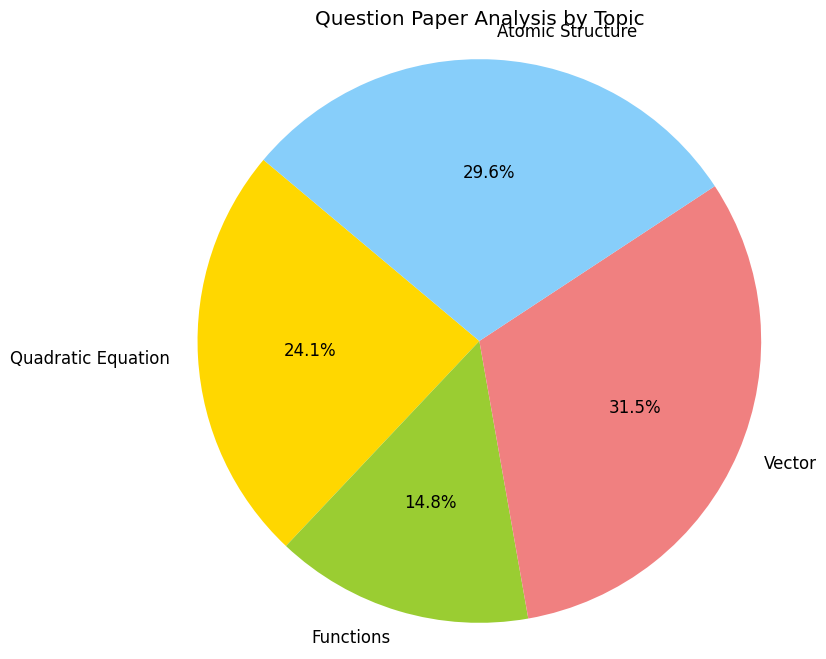

In [37]:
def generate_pie_chart(total_topics_count, output_path):
    labels = list(total_topics_count.keys())
    sizes = list(total_topics_count.values())
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange', 'lightpink', 'lightgreen']
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Question Paper Analysis by Topic')
    
    plt.savefig(output_path)
    plt.close()

# Example usage
output_path = 'dpp/question_paper_analysis_pie_chart.png'
generate_pie_chart(total_topics_count, output_path)

In [38]:
def generate_bar_chart(weak_topics, student_name):
    plt.rcParams.update({'font.size': 12})
    topics = list(weak_topics.keys())
    fractions = list(weak_topics.values())

    plt.figure(figsize=(20, 6))  # Set the figure size
    plt.bar(topics, fractions, color='skyblue')
    
    plt.ylabel('Fraction of Questions Attempted Wrong')
    plt.xlabel('Topics: Arranged in order of Most to Least Weak')    
    # Annotate the bars with the percentage values
    for index, value in enumerate(fractions):
        plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'dpp/{student_name}_bar_chart.png')
    #plt.show()
    plt.close()

In [40]:

def generate_pdf(weak_topic_dict, question_bank):
    for student, weak_topics in weak_topic_dict.items():
        generate_bar_chart(weak_topics, student)
        
        pdf_file = f'dpp/{student}_DPP.pdf'
        doc = SimpleDocTemplate(pdf_file, pagesize=A4)
        styles = getSampleStyleSheet()
        # Add custom styles
        header_style = ParagraphStyle(
            'Header',
            parent=styles['Normal'],
            fontSize=14,
            leading=16,
            spaceAfter=10,
            alignment=1  # Center alignment
        )
        analytics_style = ParagraphStyle(
            'Analytics',
            parent=styles['Normal'],
            fontSize=10,
            leading=12,
            spaceAfter=10,
            underline=True
        )
        centre_style = ParagraphStyle(
            'Analytics',
            parent=styles['Heading2'],
            fontSize=12,
            leading=12,
            spaceAfter=10,
            underline=True,
            alignment=1,
            fontName='Helvetica-Bold'
        )
        question_style = ParagraphStyle(
        'Question',
            parent=styles['BodyText'],
            fontSize=12,
            leading=14,
            spaceAfter=10,
            alignment=TA_LEFT,
            wordWrap='LTR'
        )
        heading2_style = ParagraphStyle(
            'Heading2',
            parent=styles['Heading2'],
            fontSize=13,
            leading=14,
            spaceAfter=10,
            alignment=1
        )
        
        story = []
        # Add header
        header_content = f"{student}<br/>MLAssist - Personalised DPP"
        story.append(Paragraph(header_content, header_style))
        
        # Add horizontal line
        line_data = [[Paragraph('', styles['Normal']), Paragraph('', styles['Normal'])]]
        table = Table(line_data, colWidths=[6 * inch, 6 * inch], spaceAfter=10)
        table.setStyle(TableStyle([('LINEBELOW', (0, 0), (-1, 0), 1, colors.black)]))
        story.append(table)
        story.append(Spacer(1, 20))
        
        
        # Add pie chart image
        story.append(Paragraph('Question Paper Analysis:', heading2_style))
        story.append(Spacer(2, 280))
        story.append(Paragraph(f'<img src="dpp/question_paper_analysis_pie_chart.png" width="300" height="300"/>', centre_style))
        story.append(Spacer(1, 10))
                
        # Add bar graph image
        story.append(Paragraph('Weak Topic Analysis:', heading2_style))
        story.append(Spacer(2,150))
        story.append(Paragraph(f'<img src="dpp/{student}_bar_chart.png" width="465" height="163"/>', styles['BodyText']))
        story.append(Spacer(1, 70))
        
        os.remove(f'dpp/{student}_bar_chart.png')
        
        # Add practice questions
        story.append(Paragraph('Practice Questions:', heading2_style))
        for topic in weak_topics:
            topic_questions = question_bank[question_bank['Chapter'] == topic]['Image Path'].tolist()
            random.shuffle(topic_questions)
            selected_questions = topic_questions[:5]  # select 3 questions for example
            
            story.append(Paragraph(f'{topic}:', centre_style))
            story.append(Spacer(1, 12))
            for i, question in enumerate(selected_questions):
                # Replace all newlines with a space
                #question = question.replace('\n', ' ')
                # Introduce a line break before options (A, B, C, D or a, b, c, d or 1, 2, 3, 4)
                #formatted_question = re.sub(r'\s*(\([A-Da-d1-4]\))', r'<br/>\1', question)
                #story.append(Paragraph(f'{i+1}) {formatted_question}', question_style))
                story.append(Image(question))
                story.append(Spacer(1, 12))
            #append a horizontal line here
            line_data = [[Paragraph('', styles['Normal']), Paragraph('', styles['Normal'])]]
            table = Table(line_data, colWidths=[6 * inch, 6 * inch], spaceAfter=10)
            table.setStyle(TableStyle([('LINEBELOW', (0, 0), (-1, 0), 1, colors.black)]))
            story.append(table)
            story.append(Spacer(1, 20))
        
        # Build the PDF
        doc.build(story)
        
# Call the function to generate the PDF
generate_pdf(weak_topic_dict, question_bank)

: 